Import and Configure GPU Memory Growth

In [2]:
import tensorflow as tf
from tensorflow.python.client import device_lib

# Check if GPU is available and set memory growth
gpus = len(tf.test.gpu_device_name())
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(f"{len(gpus)} Physical GPUs, {len(logical_gpus)} Logical GPUs")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU available")

# Print TensorFlow version and device details
print("TensorFlow Version: ", tf.__version__)
print(device_lib.list_local_devices())

No GPU available
TensorFlow Version:  2.10.0
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16851811146006026643
xla_global_id: -1
]


Import Libraries and Load Data

In [3]:
import pandas as pd

# Load the CSV file into a DataFrame
data = pd.read_csv('./portfolio_data.csv')

# Display the first few rows of the DataFrame
data.head()

,Date,AMZN,DPZ,BTC,NFLX
0,5/1/2013,248.229996,51.190983,106.250000,30.415714
1,5/2/2013,252.550003,51.987320,98.099998,30.641428
2,5/3/2013,258.049988,52.446388,112.900002,30.492857
3,5/6/2013,255.720001,53.205257,109.599998,30.098572
4,5/7/2013,257.730011,54.151505,113.199997,29.464285


PreProcessing

In [4]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Convert 'Date' column to datetime
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Split the data into training and testing sets
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Prepare the input and output for the model
def create_dataset(dataset, look_back=1):
    X, y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:(i + look_back), :])
        y.append(dataset[i + look_back, :])
    return np.array(X), np.array(y)

look_back = 10
X_train, y_train = create_dataset(train_data, look_back)
X_test, y_test = create_dataset(test_data, look_back)

# Display shapes of the datasets
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1206, 10, 4), (1206, 4), (294, 10, 4), (294, 4))

Build and Train

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from keras.models import load_model

# Define the neural network model
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(look_back, X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=100, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=X_train.shape[2]))  # Output layer has same number of units as the number of features

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=500, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')
model.save('mv1')

Epoch 1/500
38/38 [==============================] - 4s 30ms/step - loss: 0.0090 - val_loss: 0.0208
Epoch 2/500
38/38 [==============================] - 0s 12ms/step - loss: 0.0019 - val_loss: 0.0097
Epoch 3/500
38/38 [==============================] - 0s 12ms/step - loss: 0.0015 - val_loss: 0.0053
Epoch 4/500
38/38 [==============================] - 0s 12ms/step - loss: 0.0013 - val_loss: 0.0038
Epoch 5/500
38/38 [==============================] - 0s 12ms/step - loss: 0.0012 - val_loss: 0.0044
Epoch 6/500
38/38 [==============================] - 0s 12ms/step - loss: 0.0013 - val_loss: 0.0032
Epoch 7/500
38/38 [==============================] - 0s 12ms/step - loss: 0.0011 - val_loss: 0.0045
Epoch 8/500
38/38 [==============================] - 0s 12ms/step - loss: 0.0011 - val_loss: 0.0042
Epoch 9/500
38/38 [==============================] - 0s 13ms/step - loss: 0.0011 - val_loss: 0.0036
Epoch 10/500
38/38 [==============================] - 0s 12ms/step - loss: 9.4572e-04 - val_loss: 0.

INFO:tensorflow:Assets written to: mv1\assets


INFO:tensorflow:Assets written to: mv1\assets


Predict and Plot

10/10 [==============================] - 1s 4ms/step


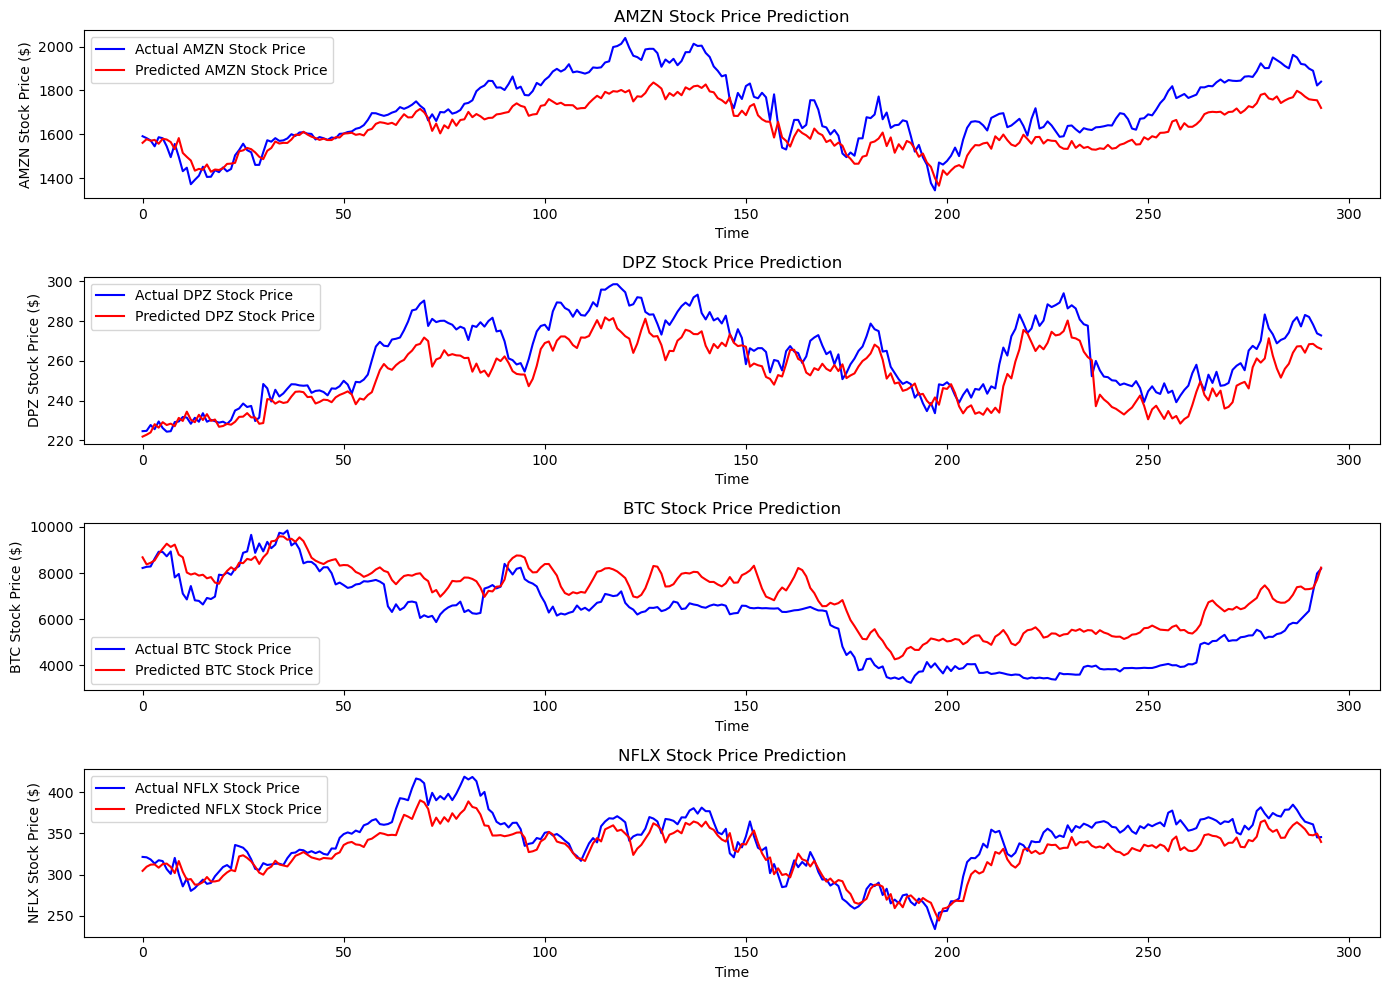

In [6]:
import matplotlib.pyplot as plt
from keras.models import load_model
#model = load_model('mv1')

# Make predictions
predictions = model.predict(X_test)

# Inverse transform the predictions and the actual values
# Create empty arrays with the same shape as scaled_data for inverse transformation
predictions_full = np.zeros_like(scaled_data)
actual_values_full = np.zeros_like(scaled_data)

# Fill the relevant portions with predictions and actual values
predictions_full[look_back:look_back+len(predictions), -predictions.shape[1]:] = predictions
actual_values_full[look_back:look_back+len(y_test), -y_test.shape[1]:] = y_test

# Perform inverse transformation
predictions = scaler.inverse_transform(predictions_full)[look_back:look_back+len(predictions), -predictions.shape[1]:]
actual_values = scaler.inverse_transform(actual_values_full)[look_back:look_back+len(y_test), -y_test.shape[1]:]

# Plot the actual vs predicted values for each company
companies = data.columns

plt.figure(figsize=(14, 10))
for i, company in enumerate(companies):
    plt.subplot(len(companies), 1, i+1)
    plt.plot(actual_values[:, i], color='blue', label=f'Actual {company} Stock Price')
    plt.plot(predictions[:, i], color='red', label=f'Predicted {company} Stock Price')
    plt.title(f'{company} Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel(f'{company} Stock Price ($)')
    plt.legend()

plt.tight_layout()
plt.show()